In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight


In [5]:
# Load dataset
data = np.load('/content/pneumoniamnist.npz')
x_train = data['train_images']
y_train = data['train_labels'].ravel()
x_val = data['val_images']
y_val = data['val_labels'].ravel()
x_test = data['test_images']
y_test = data['test_labels'].ravel()

In [6]:
# Preprocess: reshape, convert grayscale to RGB, resize, normalize
def preprocess(images):
    images = np.expand_dims(images, axis=-1)       # (H, W) -> (H, W, 1)
    images = np.repeat(images, 3, axis=-1)          # (H, W, 1) -> (H, W, 3)
    images = tf.image.resize(images, [224, 224])    # Resize
    return images / 255.0

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)

In [7]:
# Build ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [9]:
# Class imbalance handling
class_weights_dict = dict(enumerate(
    class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))

In [10]:

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('resnet50_pneumonia.keras', save_best_only=True)
]

In [11]:
# Train basic model (no augmentation)
model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.5556 - auc: 0.5116 - loss: 0.8206 - precision: 0.9101 - recall: 0.5626 - val_accuracy: 0.7424 - val_auc: 0.4856 - val_loss: 0.6883 - val_precision: 0.7424 - val_recall: 1.0000
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.4968 - auc: 0.4841 - loss: 0.8243 - precision: 0.8929 - recall: 0.4978 - val_accuracy: 0.7424 - val_auc: 0.4528 - val_loss: 0.6863 - val_precision: 0.7424 - val_recall: 1.0000
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.5582 - auc: 0.5420 - loss: 0.7265 - precision: 0.9134 - recall: 0.5635 - val_accuracy: 0.8034 - val_auc: 0.6368 - val_loss: 0.6906 - val_precision: 0.8341 - val_recall: 0.9177
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.5185 - auc: 0.5316 - loss: 0.7262 - precision: 0.9027 - recall: 0.5227 - val_accuracy: 0.7424 - val_auc: 0.7003 - val_loss: 0.6770 - val_precision: 0.7424 - val_recall: 1.0000
Epoch 5/10
122/122 ━━

In [ ]:
# Optional: Fine-tune top layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

In [ ]:

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
# Re-train with augmentation
model.fit(
    train_generator,
    validation_data=(x_val, y_val),
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


In [12]:

# Evaluate
test_loss, test_acc, test_auc, test_prec, test_recall = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.6135 - auc: 0.7905 - loss: 0.6745 - precision: 0.6135 - recall: 1.0000
Test Accuracy: 0.6250, AUC: 0.7733, Precision: 0.6250, Recall: 1.0000


In [13]:
# Predict & evaluate
y_pred_probs = model.predict(x_test).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=["Normal", "Pneumonia"]))

auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC Score: {auc_score:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step

Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

AUC Score: 0.8585


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


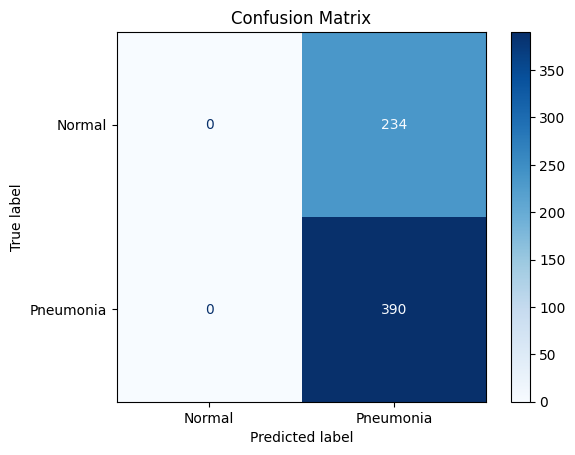

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

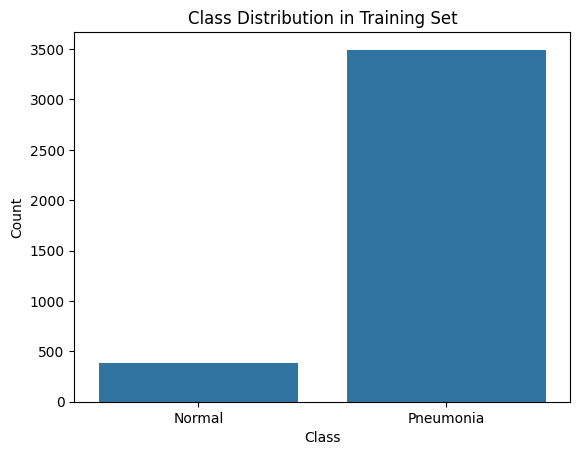

In [15]:
# Class balance check
sns.barplot(x=[0, 1], y=np.bincount(y_train))
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Normal", "Pneumonia"])
plt.show()


In [3]:
!pip freeze > requirements.txt


In [4]:
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>